# Interact with Doctor in Training
## Role: Health Education England

## This notebook walks through how to issue a credential across a newly established connection with a mobile SSI agent. 

## Before running through this notebook you should run through the following notebook - [Part 4.1](http://localhost:8891/notebooks/Part%204.1%20-%20Initialising%20the%20HEE%20Agent.ipynb).

## Or alternatively you can start at the beginning of the Doctors in Training flow [here](http://localhost:8889/notebooks/Part%201%20-%20Getting%20Started.ipynb).



## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8042
WEBHOOK_BASE = ""
ADMIN_URL = "http://hee-agent:8041"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scans this QR code and then can communicate with the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

You must have a ssi wallet installed on your phone and connected to the Sovrin StagingNet for this to work.

### 3.1 Generate an invitation

In [3]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'connection_id': 'c500fd39-5aad-41ab-8821-daf369cce680', 'state': 'invitation', 'invitation_key': '7DgppFUinU6Fs7PMap1ELHg1iZvYnWdxc6RsjWAU1PpX', 'updated_at': '2020-09-21 15:54:12.981561Z', 'routing_state': 'none', 'accept': 'auto', 'created_at': '2020-09-21 15:54:12.981561Z', 'initiator': 'self', 'invitation_mode': 'once'} c500fd39-5aad-41ab-8821-daf369cce680
Connection ID c500fd39-5aad-41ab-8821-daf369cce680
Invitation
https://1c4cdf2a9574.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMTk2MzY1ZmMtMzRkOC00N2YyLTk0M2UtMDA3YjliMzA0Njg1IiwgInJlY2lwaWVudEtleXMiOiBbIjdEZ3BwRlVpblU2RnM3UE1hcDFFTEhnMWladlluV2R4YzZSc2pXQVUxUHBYIl0sICJsYWJlbCI6ICJNZWRpY2FsIFNjaG9vbCIsICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly8xYzRjZGYyYTk1NzQubmdyb2suaW8ifQ==


### 3.2 Display as QrCode to be Scanned by SSI Wallet

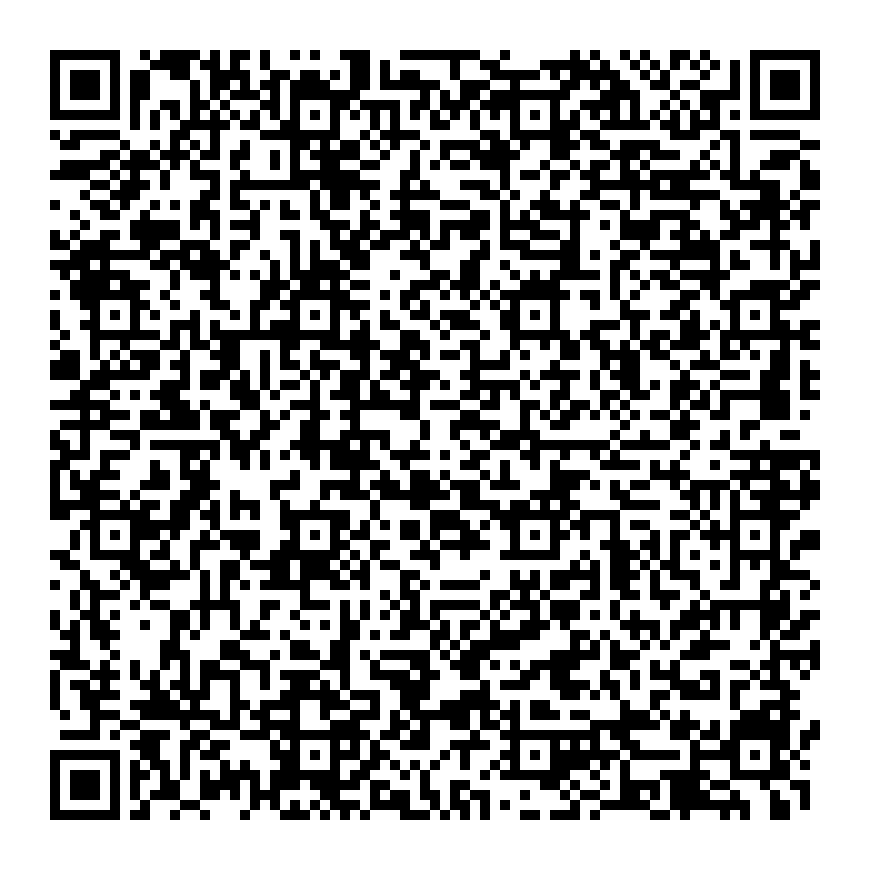

In [7]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### 3.3 Check the connection is in the active state

In [6]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId c500fd39-5aad-41ab-8821-daf369cce680 is invitation
ConnectionId c500fd39-5aad-41ab-8821-daf369cce680 is not in active state yet


ClientResponseError: 400, message='Connection c500fd39-5aad-41ab-8821-daf369cce680 not ready', url=URL('http://hee-agent:8041/connections/c500fd39-5aad-41ab-8821-daf369cce680/send-ping')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

## 4 Issue a Training Program Credential

### 4.1 Fetch the associated credential definition id written to the Ledger in Part 4.1

This will fail if a credential definition has not been written to the ledger by the HEE agent's public DID.

In [6]:
response = await agent_controller.wallet.get_public_did()
print(response)
hee_public_did = response["result"]["did"]
training_program_schema_id = "2yWoMSfeTtYBFpUJFcnpqL:2:Training Programme:0.0.1"
definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=training_program_schema_id)

training_program_cred_def_id = None
cred_def_ids = definitions['credential_definition_ids']
if len(cred_def_ids) == 0:
    print("You have not written a credential definition to the ledger for this public DID")
else:
    training_program_cred_def_id = cred_def_ids[0]
    print(training_program_cred_def_id)
    


{'result': {'did': 'JZRP2ZvHL5563vdgWVTF5V', 'verkey': 'Aa5Gw22pwRxBZAVuVPzQGoeBWMV3qATJZBaNcaz6QXwv', 'public': True}}
JZRP2ZvHL5563vdgWVTF5V:3:CL:141258:default


### 4.2 Populate the Training Program attributes to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [7]:
lead_employee = input("Please enter the doctors lead employee: ")
clinical_supervisor=input("Please enter the doctors clinical supervisor: ")
academic_supervisor=input("Please enter the doctors academic supervisor: ")
program_name = input("Please enter the name of the training program: ")
program_year=input("Please enter the current year of the program: ")
start_date=input("Please enter the programs start date: ")
scheduled_end = input("Please enter the scheduled end date: ")
extended_end=input("Please enter the extended_end_date: ")

credential_attributes = [
    {"name": "TPR Lead Employer", "value": lead_employee},
    {"name": "TPR Clinical Supervisor", "value": clinical_supervisor},
    {"name": "TPR Academic Supervisor", "value": academic_supervisor},
    {"name": "TPR Training Programme Name", "value": program_name},
    {"name": "TPR Programme Current Year", "value": program_year},
    {"name": "TPR Start Date", "value": start_date},
    {"name": "TPR Scheduled End Date", "value": scheduled_end},
    {"name": "TPR Extended End Date", "value": extended_end},

]




print(credential_attributes)

Please enter the doctors lead employee: BTH
Please enter the doctors clinical supervisor: me
Please enter the doctors academic supervisor: you
Please enter the name of the training program: training good
Please enter the current year of the program: 2020
Please enter the programs start date: today
Please enter the scheduled end date: tomorrow
Please enter the extended_end_date: wednesday
[{'name': 'TPR Lead Employer', 'value': 'BTH'}, {'name': 'TPR Clinical Supervisor', 'value': 'me'}, {'name': 'TPR Academic Supervisor', 'value': 'you'}, {'name': 'TPR Training Programme Name', 'value': 'training good'}, {'name': 'TPR Programme Current Year', 'value': '2020'}, {'name': 'TPR Start Date', 'value': 'today'}, {'name': 'TPR Scheduled End Date', 'value': 'tomorrow'}, {'name': 'TPR Extended End Date', 'value': 'wednesday'}]


## 4.3 Issue Training Program Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [17]:
record = await agent_controller.issuer.send_credential(connection_id, training_program_schema_id, training_program_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


{'issuer_did': 'XWp3vCdafbfAEthny5mERo', 'auto_remove': True, 'credential_proposal': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/credential-preview', 'attributes': [{'name': 'fullname', 'value': 'Ronnie'}, {'name': 'skill', 'value': 'PyDentity SSI Ninja'}, {'name': 'age', 'value': '23'}]}, 'connection_id': 'd36df176-2428-46e4-937d-26eef701d292', 'trace': False, 'comment': '', 'cred_def_id': 'XWp3vCdafbfAEthny5mERo:3:CL:142409:default', 'schema_id': 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1', 'schema_name': 'SSI PyDentity Tutorial', 'schema_version': '0.0.1', 'schema_issuer_did': 'EuEtnVakYFyBtGFT1nHYtH'}
Credential exchange 8f4d27a9-9034-45cc-829d-47514c7c976b, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 8f4d27a9-9034-45cc-829d-47514c7c976b, role: issuer, state: offer_sent
Offering: [{'name': 'fullname', 'value': 'Ronnie'}, {'name': 'skill', 'value': 'PyDentity SSI Ninja'}, {'name': 'age', 'value': '23'}]
Handle Credential

## 5. Issue Mandatory Training Credential

### 5.1 Fetch the credential definition for the schema


In [ ]:
response = await agent_controller.wallet.get_public_did()
print(response)
hee_public_did = response["result"]["did"]
mandatory_training_schema_id = "2yWoMSfeTtYBFpUJFcnpqL:2:mandatoryTrainingCredential:0.0.1"
definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=mandatory_training_program_schema_id)

mandatory_training_cred_def_id = None
cred_def_ids = definitions['credential_definition_ids']
if len(cred_def_ids) == 0:
    print("You have not written a credential definition to the ledger for this public DID")
else:
    mandatory_training_cred_def_id = cred_def_ids[0]
    print(tmandatory_training_cred_def_id)
    


### 5.2 Populate the Mandatory Training Credential Attributes

In [8]:
expiry_date = input("Please enter the expiry date for all training :")

credential_attributes=[
    {"name":"MNT Conflict Resolution Completed", "value": "True"},
     {"name":"MNT Conflict Resolution Expiry Date", "value": expiry_date},
     {"name":"MNT Equality and Diversity Completed", "value": "True"},
     {"name":"MNT Equality and Diversity Expiry Date", "value": expiry_date},
     {"name":"MNT Fire Safety Completed", "value": "True"},
     {"name":"MNT Fire Safety Expiry Date", "value": expiry_date},
     {"name":"MNT Health Safety and Welfare Completed", "value": "True"},
     {"name":"MNT Health Safety and Welfare Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L1 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L2 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Information Governance Completed", "value": "True"},
     {"name":"MNT Information Governance Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L1 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L2 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Basic Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Basic Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L1 Completed", "value": "True"},
     {"name":"MNT Resus L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L2 Adult Completed", "value": "True"},
     {"name":"MNT Resus L2 Adult Expiry Date","value": expiry_date},
     {"name":"MNT Resus L2 Newborn Completed", "value": "True"},
     {"name":"MNT Resus L2 Newborn Expiry Date", "value": expiry_date},
     {"name": "MNT Resus L2 Paediatric Completed", "value": "True"},
     {"name":"MNT Resus L2 Paediatric Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Violence and Aggression Completed", "value": "True"},
     {"name":"MNT Violence and Aggression Expiry Date", "value": expiry_date}
]
print(credential_attributes)


Please enter the expiry date for all training :01/01/2020
[{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expiry Date', 'value': '01/01/2020'}, {'name': 'MNT Information Governance Completed', 'value': 'True'}, {'name': 'MNT Information Governance Exp

### 5.3 Issue the Mandatory Training Credential 

In [ ]:
record = await agent_controller.issuer.send_credential(connection_id, mandatory_training_schema_id, mandatory_training_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

## 6. Issue Training Placement Credential

### 6.1 Fetch the relevant credential definition

In [9]:

response = await agent_controller.wallet.get_public_did()
hee_public_did = response["result"]["did"]
training_placement_schema_id = "2yWoMSfeTtYBFpUJFcnpqL:2:Training Programme Placement:0.0.1"
definitions = await agent_controller.definitions.search_created(issuer_did=hee_public_did, schema_id=training_placement_schema_id)

training_placement_cred_def_id = None
cred_def_ids = definitions['credential_definition_ids']
if len(cred_def_ids) == 0:
    print("You have not written a credential definition to the ledger for this public DID")
else:
    training_placement_cred_def_id = cred_def_ids[0]
    print(training_placement_cred_def_id)
    

{'result': {'did': 'JZRP2ZvHL5563vdgWVTF5V', 'verkey': 'Aa5Gw22pwRxBZAVuVPzQGoeBWMV3qATJZBaNcaz6QXwv', 'public': True}}
JZRP2ZvHL5563vdgWVTF5V:3:CL:141276:default


### 6.2 Populate the Training Placement Credential Attributes

In [10]:
placement_name = input("Please enter the name of the placement: ")
employer=input("Please enter the placement employer: ")
location=input("Please enter the location of the placement: ")
start_date = input("Please enter the placement start date: ")
sched_end_date =input("Please enter the scheduled end of the placement: ")
extended_end_date=input("Please enter the extended end date: ")
actual_end = input("Please enter the actual end date: ")
position_id =input("Please enter the placements position id: ")

credential_attributes = [
     {"name":"TPP Placement Name", "value": placement_name},
     {"name":"TPP Placement Employer", "value": employer},
     {"name":"TPP Placement Location", "value": location},
     {"name":"TPP Placement StartDate", "value": start_date},
     {"name":"TPP Placement Sched End Date", "value": sched_end_date},
     {"name":"TPP Placement Ext. End Date", "value": extended_end_date},
     {"name":"TPP Placement Act End Date", "value": actual_end},
     {"name":"TPP PositionId", "value": position_id}
]
print(credential_attributes)

Please enter the name of the placement: Test
Please enter the placement employer: bth
Please enter the location of the placement: blackpool
Please enter the placement start date: today
Please enter the scheduled end of the placement: tomorrow
Please enter the extended end date: wednesdayt
Please enter the actual end date: thursday
Please enter the placements position id: 123


### 6.3 Issue the Training Placement Credential

In [ ]:
record = await agent_controller.issuer.send_credential(connection_id, training_placement_schema_id, training_placement_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

## 7. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [12]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the [Lead Employer](http://127.0.0.1:8892)
